### data was taken from kaggle (https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data)

#### Notebook was run on kaggle platform because GPU needed.

In [1]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
labels = pd.read_csv("../input/rsna-heart-detection/rsna_heart_detection.csv")
labels.head()

,label,x0,y0,w,h,name,img_shape_x,img_shape_y
0,heart,91,71,77,102,ca112a3c-b701-48b8-a94f-725ea65416a7,224,224
1,heart,70,64,89,67,e5f292ae-f1e5-497c-b0a0-68f1aa2196b2,224,224
2,heart,82,55,81,76,67af68f7-7ba0-49a0-a373-3a8801eb0faa,224,224
3,heart,93,74,78,89,814289a3-9ce8-4cba-842f-45d6a36f540d,224,224
4,heart,85,61,85,93,e508969f-c931-462b-aa90-ccde34a4d9e5,224,224


In [3]:
ROOT_PATH = Path("../input/rsna-pneumonia-detection-challenge/stage_2_train_images/")
SAVE_PATH = Path("../Processed-Heart-Detection")

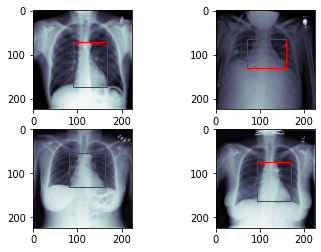

In [4]:
fig, axis = plt.subplots(2 ,2)
c = 0
for i in range(2):
    for j in range(2):
        data = labels.iloc[c]
        patient_id = data["name"]
        dcm_path = ROOT_PATH/str(patient_id)  # Create the path to the dcm file
        dcm_path =dcm_path.with_suffix(".dcm")
        
        dcm = pydicom.read_file(dcm_path)
        dcm_array = dcm.pixel_array
        dcm_array = cv2.resize(dcm_array, (224,224))
        
        x = data["x0"]
        y = data["y0"]
        width = data["w"]
        height = data["h"]
        
        axis[i][j].imshow(dcm_array, cmap="bone")
        rect = patches.Rectangle((x,y), width, height, linewidth=1, edgecolor="r", facecolor="none")
        axis[i][j].add_patch(rect)
        c+=1

In [5]:
sums = 0
sums_squared = 0
train_ids = []
val_ids = []

for counter, patient_id in enumerate(list(labels.name)):
    dcm_path = ROOT_PATH/str(patient_id)  # Create the path to the dcm file
    dcm_path = dcm_path.with_suffix(".dcm")  # And add the .dcm suffix
    
    dcm = pydicom.read_file(dcm_path)  # Read the dicom file with pydicom
    
    # Retrieve the actual image 
    dcm_array = dcm.pixel_array
        
    # Resize the image to drastically improve training speed
    # In order to reduce the space when storing the image we convert it to float16
    # Standardize to 0-1 range
    dcm_array = (cv2.resize(dcm_array, (224, 224)) / 255).astype(np.float16)
          
    # 4/5 train split, 1/5 val split
    train_or_val = "train" if counter < 400 else "val" 
    
    # Add to corresponding train or validation patient index list
    if train_or_val =="train":
        train_ids.append(patient_id)
    else:
        val_ids.append(patient_id)
        
    current_save_path = SAVE_PATH/train_or_val # Define save path and create if necessary
    current_save_path.mkdir(parents=True, exist_ok=True)
    
    np.save(current_save_path/patient_id, dcm_array) # Save the array in the corresponding directory
    
    normalizer = 224*224
    if train_or_val == "train":
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (dcm_array**2).sum() / normalizer

In [6]:
np.save("../Processed-Heart-Detection/train_subjects", train_ids)
np.save("../Processed-Heart-Detection/val_subjects", val_ids)

In [7]:
mean = sums /len(train_ids)
std = np.sqrt((sums_squared / len(train_ids)) - mean**2)
mean, std

(0.49430165816326493, 0.2527964897943661)

In [8]:
from pathlib import Path
import torch
import numpy as np
import pandas as pd
import imgaug
from imgaug.augmentables.bbs import BoundingBox

#### DataSet Creation
Now we define the torch dataset!
We need to define a __ len __ function which returns the length of the dataset and a __ getitem __ function which returns the image and corresponding bounding box.

Additionally we apply data augmentation and normalization.

**Important**: Augment bounding box together with image!<br />
You can use *BoundingBox(x1, y1, x2, y2) for that*.<br />
Next you call *self.augment(image=img, bounding_boxes=bb)* which returns the augmented image and bounding boxes<br />
Finally you extract the coordinates from the augmented bbox coordinates. Note that it is a 2D array.
```python
bb = BoundingBox(x1=bbox[0], y1=bbox[1], x2=bbox[2], y2=bbox[3])
img, aug_bbox  = self.augment(image=img, bounding_boxes=bb)
bbox = aug_bbox[0][0], aug_bbox[0][1], aug_bbox[1][0], aug_bbox[1][1]
```

In [9]:
class CardiacDataset(torch.utils.data.Dataset):
    
    def __init__(self, path_to_labels_csv, patients, root_path, augs):
        
        self.labels = pd.read_csv(path_to_labels_csv)
        self.patients = np.load(patients)
        self.root_path = Path(root_path)
        self.augment = augs
        
    def __len__(self):
        return len(self.patients)
    
    def __getitem__(self, idx):
        patient = self.patients[idx]
        
        # Get data according to index
        data = self.labels[self.labels["name"]==patient]
        
        # Get entries of given patient
        # Extract coordinates
        x_min = data["x0"].item()
        y_min = data["y0"].item()
        x_max = x_min + data["w"].item()
        y_max = y_min + data["h"].item()
        bbox = [x_min, y_min, x_max, y_max]
        
        # Load file and convert to float32
        file_path = self.root_path/patient  # Create the path to the file
        img = np.load(f"{file_path}.npy").astype(np.float32)
        
        # Apply imgaug augmentations to image and bounding box
        if self.augment:
            bb= BoundingBox(x1=bbox[0], y1=bbox[1], x2=bbox[2], y2=bbox[3])
            random_seed = torch.randint(0, 100000, (1,)).item()
            imgaug.seed(random_seed)
            
            img, aug_bbox = self.augment(image=img, bounding_boxes=bb)
            bbox = aug_bbox[0][0], aug_bbox[0][1], aug_bbox[1][0], aug_bbox[1][1]
            
        # Normalize the image according to the values computed in Preprocessing    
        img = (img -0.494) / 0.252
        img = torch.tensor(img).unsqueeze(0)
        bbox = torch.tensor(bbox)
        return img, bbox

In [10]:
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [11]:
seq = iaa.Sequential([
    iaa.GammaContrast(),
    iaa.Affine(
    scale=(0.8, 1.2),
    rotate=(-10, 10),
    translate_px=(-10, 10))
])

In [12]:
labels_path = "../input/rsna-heart-detection/rsna_heart_detection.csv"
patients_path = "../Processed-Heart-Detection/train_subjects.npy"
train_root = "../Processed-Heart-Detection/train/"
dataset = CardiacDataset(labels_path, patients_path, train_root, seq)

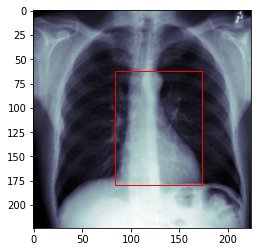

In [13]:
img, bbox = dataset[0]

fig, axis = plt.subplots(1, 1)
axis.imshow(img[0], cmap="bone")
rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], edgecolor="r", facecolor="none")
axis.add_patch(rect)

# run this cell more than one. every run correctly sign the heart

tensor([ 73.3539,  58.0398, 188.7822, 191.0626])


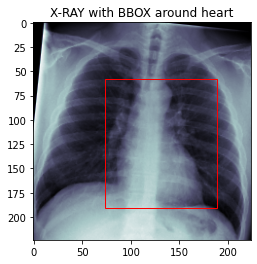

In [14]:
img, label = dataset[17]

fig, axis = plt.subplots(1, 1)
axis.imshow(img[0], cmap="bone")
spot1 = patches.Rectangle((label[0], label[1]), label[2]-label[0], label[3]-label[1], edgecolor='r', facecolor='none')
axis.add_patch(spot1)

axis.set_title("X-RAY with BBOX around heart")
print(label)

In [15]:
# import module we'll need to import our custom module
from shutil import copyfile

# copy our file into the working directory (make sure it has .py suffix)
copyfile(src = "../input/dataset/dataset_.py", dst = "../working/dataset_.py") 

'../working/dataset_.py'

In [16]:
import torch
import torchvision
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np
import cv2
import imgaug.augmenters as iaa
from dataset_ import CardiacDataset

In [17]:
train_root_path = "../Processed-Heart-Detection/train"
train_subjects = "../Processed-Heart-Detection/train_subjects.npy"
val_root_path = "../Processed-Heart-Detection/val"
val_subjects = "../Processed-Heart-Detection/val_subjects.npy"

train_transformers = iaa.Sequential([
    iaa.GammaContrast(),
    iaa.Affine(
        scale=(0.8, 1.2),
        rotate=(-10, 10),
        translate_px=(-10, 10))
    
])

In [18]:
train_dataset = CardiacDataset("../input/rsna-heart-detection/rsna_heart_detection.csv", train_subjects, train_root_path, train_transformers)
val_dataset = CardiacDataset("../input/rsna-heart-detection/rsna_heart_detection.csv", val_subjects, val_root_path, None)

In [19]:
batch_size = 8
num_workers = 4

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [20]:
class CardiacDetectionModel(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        
        self.model = torchvision.models.resnet18(pretrained=True)  #transfer learning
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=4)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.MSELoss()
        
    def forward(self, data):
        return self.model(data)
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)
        
        self.log("Train Loss", loss)
        
        if batch_idx % 50 ==0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Train")
        return loss
    
    def validation_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)
        
        self.log("Val Loss", loss)
        
        if batch_idx % 50 ==0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Val")
        return loss
    
    def log_images(self, x_ray, pred, label, name):
        results = []
        
        # Here we create a grid consisting of 4 predictions
        for i in range(4):
            coords_labels = label[i]
            coords_pred = pred[i]
            
            img = ((x_ray[i] * 0.252) + 0.494).numpy()[0]
            
            # Extract the coordinates from the label
            x0, y0 = coords_labels[0].int().item(), coords_labels[1].int().item()
            x1, y1 = coords_labels[2].int().item(), coords_labels[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (0, 0, 0), 2)
            
            # Extract the coordinates from the prediction
            x0, y0 = coords_pred[0].int().item(), coords_pred[1].int().item()
            x1, y1 = coords_pred[2].int().item(), coords_pred[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (0, 0, 0), 2)
            
            results.append(torch.tensor(img).unsqueeze(0))
        
        grid = torchvision.utils.make_grid(results, 2)
        self.logger.experiment.add_image(name, grid, self.global_step)
        
    def configure_optimizers(self):
        return [self.optimizer]

In [21]:
model = CardiacDetectionModel()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [22]:
checkpoint_callback = ModelCheckpoint(
    monitor="Val Loss",
    save_top_k=10,
    mode="min"    
)

In [23]:
# Create the trainer
# Change the gpus parameter to the number of available gpus in your computer. Use 0 for CPU training

gpus = 1 #TODO
trainer = pl.Trainer(gpus=gpus, logger=TensorBoardLogger("./logs"), log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     max_epochs=100)

# trainer = pl.Trainer(logger=TensorBoardLogger("./logs"), log_every_n_steps=1, callbacks=checkpoint_callback, max_epochs=100)

In [24]:
trainer.fit(model, train_loader, val_loader)

Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.load_from_checkpoint("logs/default/version_0/checkpoints/epoch=72-step=3649.ckpt")
model.eval();
model.to(device)

CardiacDetectionModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [30]:
preds = []
labels =[]

with torch.no_grad():
    for data, label in val_dataset:
        data = data.to(device).float().unsqueeze(0)
        pred = model(data)[0].cpu()
        preds.append(pred)
        labels.append(label)
        
preds=torch.stack(preds)
labels=torch.stack(labels)

In [31]:
abs(preds-labels).mean(0)

tensor([5.1160, 5.1738, 4.9433, 5.5877])

tensor([ 90,  69, 185, 182])


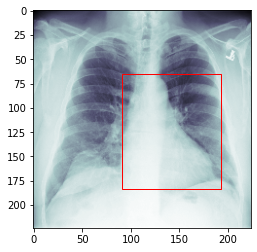

In [33]:
IDX = 19  # Feel free to inspect all validation samples by changing the index
img, label = val_dataset[IDX]
current_pred = preds[IDX]

fig, axis = plt.subplots(1, 1)
axis.imshow(img[0], cmap="bone")
heart = patches.Rectangle((current_pred[0], current_pred[1]), current_pred[2]-current_pred[0],
                          current_pred[3]-current_pred[1], linewidth=1, edgecolor='r', facecolor='none')
axis.add_patch(heart)

print(label)